In [ ]:
# тест на стационарность и попытка предсказать с помощью ARIMA

In [1]:
# импорт
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# получение данных

# сам датафрейм
df = pd.read_csv('../data/gdelt_counts_event_by_day.csv', delimiter=',');

# названия столбцов
cameo = pd.read_csv('../data/gdelt_eventcodes.txt', sep='\t');

# устанавливаем индексы
df = df.set_index('date')
cameo = cameo.set_index('CAMEOEVENTCODE')

# удаляем лишнее и преобразуем формат
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('0', axis=1)
cameo.index = cameo.index.map(str)

# переименовываем
df_rename = df.rename(columns=cameo.to_dict()['EVENTDESCRIPTION'])

# заполняем пустые строки
df_rename = df_rename.fillna(0)

# меняем формат индекса
df_rename.index =  pd.to_datetime(df_rename.index, format="%Y_%m_%d")

In [3]:
# выбираем одно из полей
df_one = df_rename['EXHIBIT FORCE POSTURE']

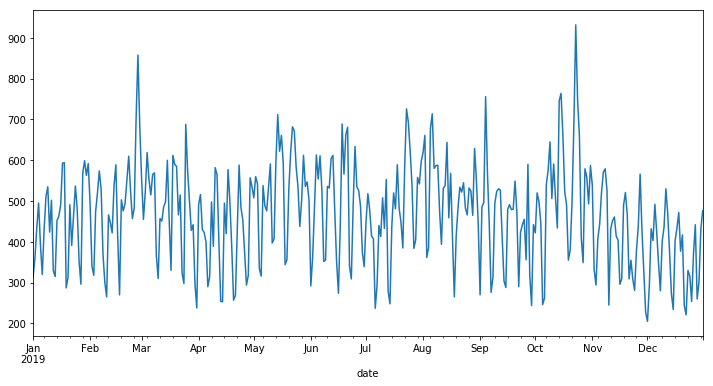

In [4]:
# посмотрим на график
df_one.plot(figsize=(12,6))

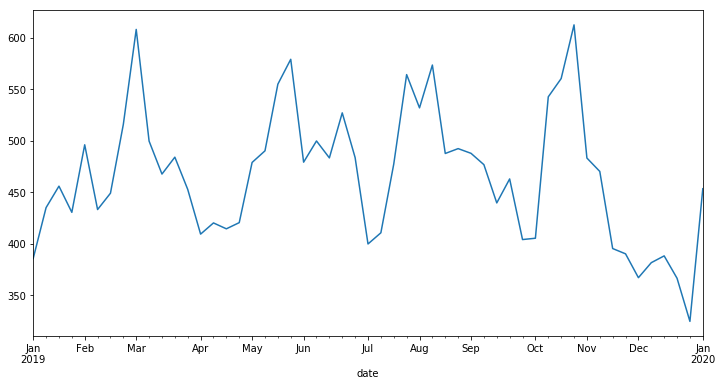

In [58]:
# усредним по неделям
df_one_w = df_one.resample('W').mean()
df_one.plot(figsize=(12,6))

count    365.000000
mean     466.589041
std      122.626256
min      205.000000
25%      379.000000
50%      476.000000
75%      545.000000
max      932.000000
Name: EXHIBIT FORCE POSTURE, dtype: float64

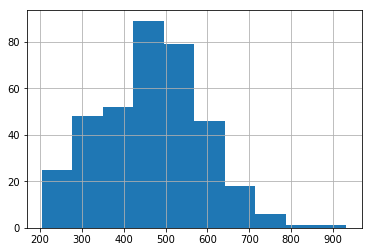

In [5]:
itog = df_one.describe()
df_one.hist()
itog

In [6]:
print('V = %f' % (itog['std']/itog['mean']))

V = 0.262814


In [7]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
[x,p] = stats.jarque_bera(df_one)
p

0.4112824877228676

In [ ]:
# следовательно распределение не нормально

In [8]:
result = adfuller(df_one)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.588737
p-value: 0.005980
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [9]:
# проверяем на стационарность
test = adfuller(df_one)
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print( 'единичных корней нет, ряд стационарен')

adf:  -3.588736875805794
p-value:  0.005980041460183936
Critical values:  {'1%': -3.449336554273722, '5%': -2.8699055166063085, '10%': -2.571226758215748}
единичных корней нет, ряд стационарен


C:\Users\ikzn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\ikzn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\ikzn\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                ARIMA Model Results                                
Dep. Variable:     D.EXHIBIT FORCE POSTURE   No. Observations:                  364
Model:                      ARIMA(5, 1, 0)   Log Likelihood               -2166.155
Method:                            css-mle   S.D. of innovations             92.691
Date:                     Sat, 14 Mar 2020   AIC                           4346.311
Time:                             11:46:00   BIC                           4373.591
Sample:                         01-02-2019   HQIC                          4357.153
                              - 12-31-2019                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0508      1.593      0.032      0.975      -3.072       3.174
ar.L1.D.EXHIBIT FORCE POSTURE    -

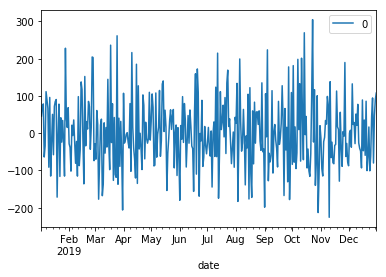

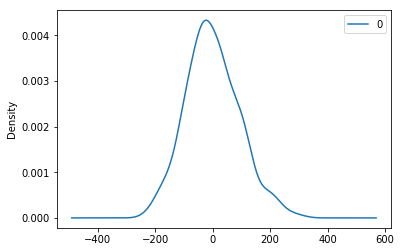

                0
count  364.000000
mean     0.258411
std     92.914116
min   -225.710196
25%    -62.218768
50%     -9.078528
75%     60.977924
max    304.355621


In [10]:
# строим модель ARIMA
model = ARIMA(df_one, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

predicted=496.781992, expected=629.000000
predicted=608.353167, expected=551.000000
predicted=476.351555, expected=443.000000
predicted=475.435049, expected=270.000000
predicted=385.504522, expected=486.000000
predicted=512.147944, expected=496.000000
predicted=525.091093, expected=756.000000
predicted=697.743987, expected=570.000000
predicted=498.269082, expected=441.000000
predicted=348.095876, expected=276.000000
predicted=389.206759, expected=313.000000
predicted=380.321367, expected=494.000000
predicted=641.094248, expected=523.000000
predicted=522.789379, expected=530.000000
predicted=502.503653, expected=527.000000
predicted=429.008873, expected=412.000000
predicted=341.949078, expected=304.000000
predicted=384.464490, expected=288.000000
predicted=402.031191, expected=480.000000
predicted=524.600191, expected=491.000000
predicted=487.160772, expected=479.000000
predicted=451.304478, expected=480.000000
predicted=422.612338, expected=549.000000
predicted=431.520954, expected=472

<Figure size 432x288 with 0 Axes>

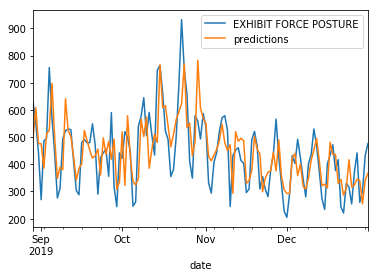

In [11]:
X = df_one
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat[0])
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plotdf = pd.DataFrame(test)
plotdf['predictions'] = predictions
plt.figure();
plotdf.plot()